In [2]:
import os
import random
import math
import re
import datetime
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


import nucleus

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# Training

#### Setting all paths

In [19]:
# Directory to save logs and trained model
ROOT_DIR = os.getcwd()
LOGS_DIR = os.path.join(ROOT_DIR, "logs_try")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_nucleus_0040.h5")
DATASET_DIR = os.path.join(ROOT_DIR, "kaggle data")

#### Configuring the model

In [16]:
DEVICE = "/gpu:0"
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [3]:
def get_ax(rows=1, cols=1, size=16):
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

#### Loading Data

In [20]:
# Training data
dataset_train = nucleus.NucleusDataset()
dataset_train.load_nucleus(DATASET_DIR, "train")
dataset_train.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Images: 645
Classes: ['BG', 'nucleus']


In [21]:
# Validation data
dataset_val = nucleus.NucleusDataset()
dataset_val.load_nucleus(DATASET_DIR, "val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 25
Classes: ['BG', 'nucleus']


#### Load Model

In [22]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIR)

#### Load Weights

In [23]:
model.load_weights(WEIGHTS_PATH, by_name=True)

#### Training the model

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=5, 
            layers="heads")

# Preparing model for Detection

#### Setting all paths

In [3]:
ROOT_DIR = os.getcwd()
LOGS_DIR = os.path.join(ROOT_DIR, "logs_try")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "final_weights.h5")
RESULTS_DIR=os.path.join(ROOT_DIR, "results")

#### Configuring the model

In [4]:
DEVICE = "/gpu:0"
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

#### Load Model

In [5]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=LOGS_DIR)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


#### Load Weights

In [6]:
model.load_weights(WEIGHTS_PATH, by_name=True)

#### Crating Results sub-directory

In [7]:
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
submit_dir = os.path.join(RESULTS_DIR, submit_dir)
os.makedirs(submit_dir)

## Detection on Custom dataset
#### Loading Data

In [11]:
DATASET_DIR = "/path to test data"
dataset = nucleus.NucleusDataset()
dataset.load_custom_nucleus(DATASET_DIR)
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 8
Classes: ['BG', 'nucleus']


#### Plotting test images

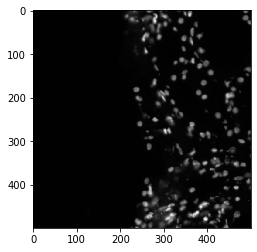

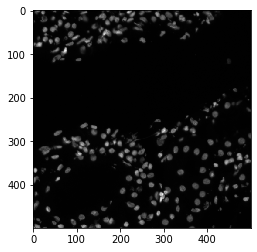

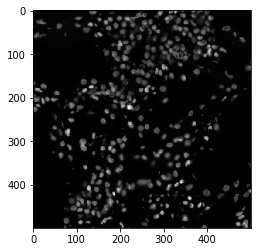

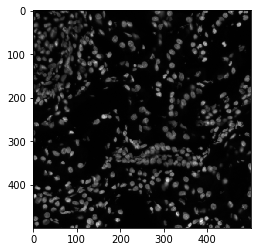

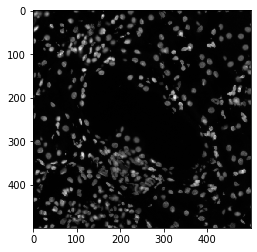

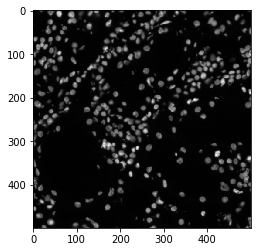

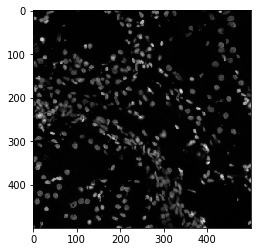

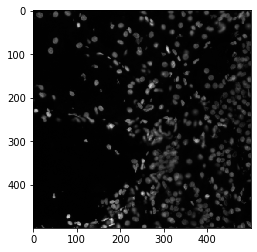

In [13]:
for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    plt.imshow(image)
    plt.show()

#### Detection

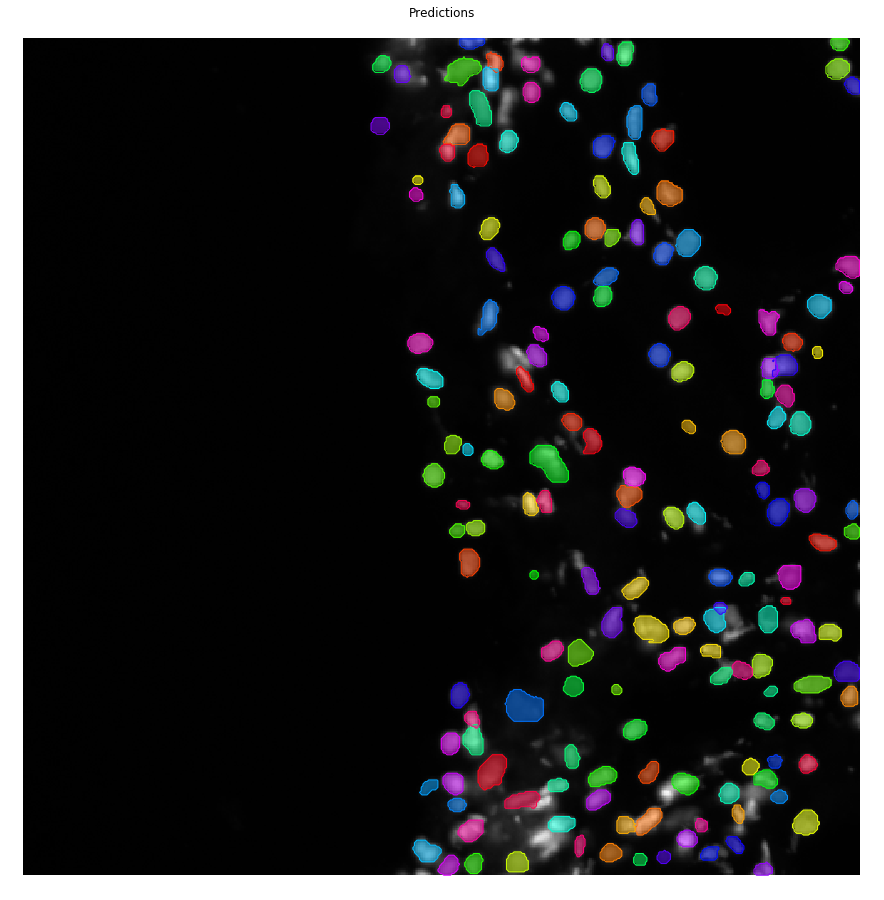

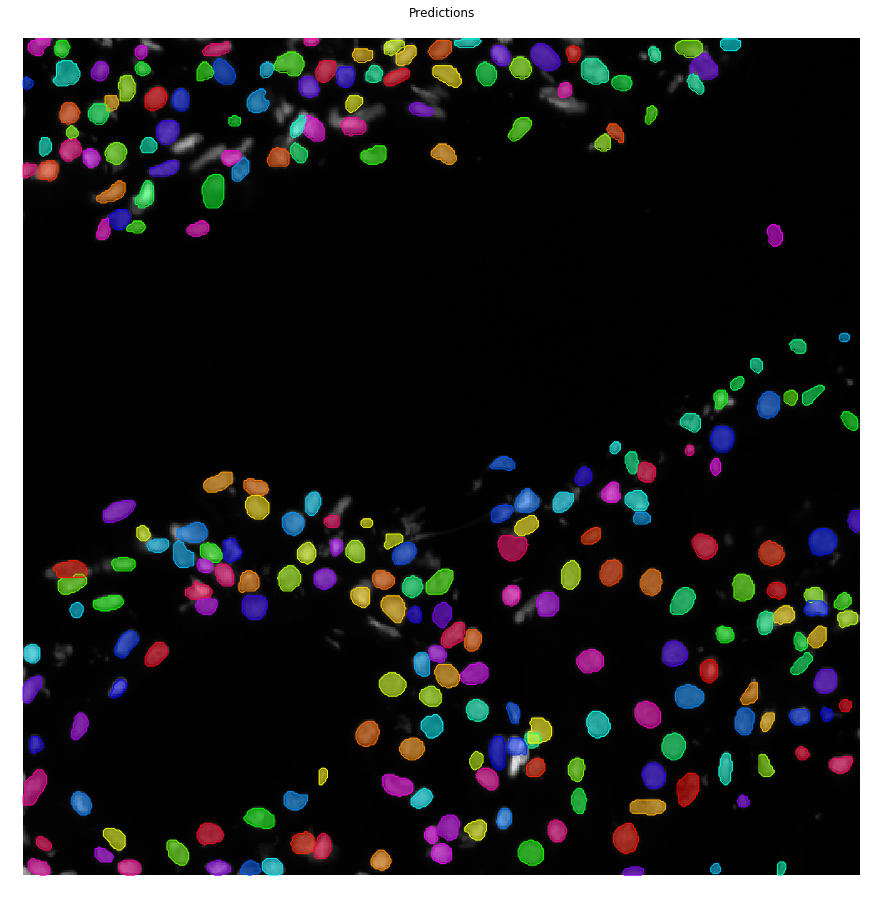

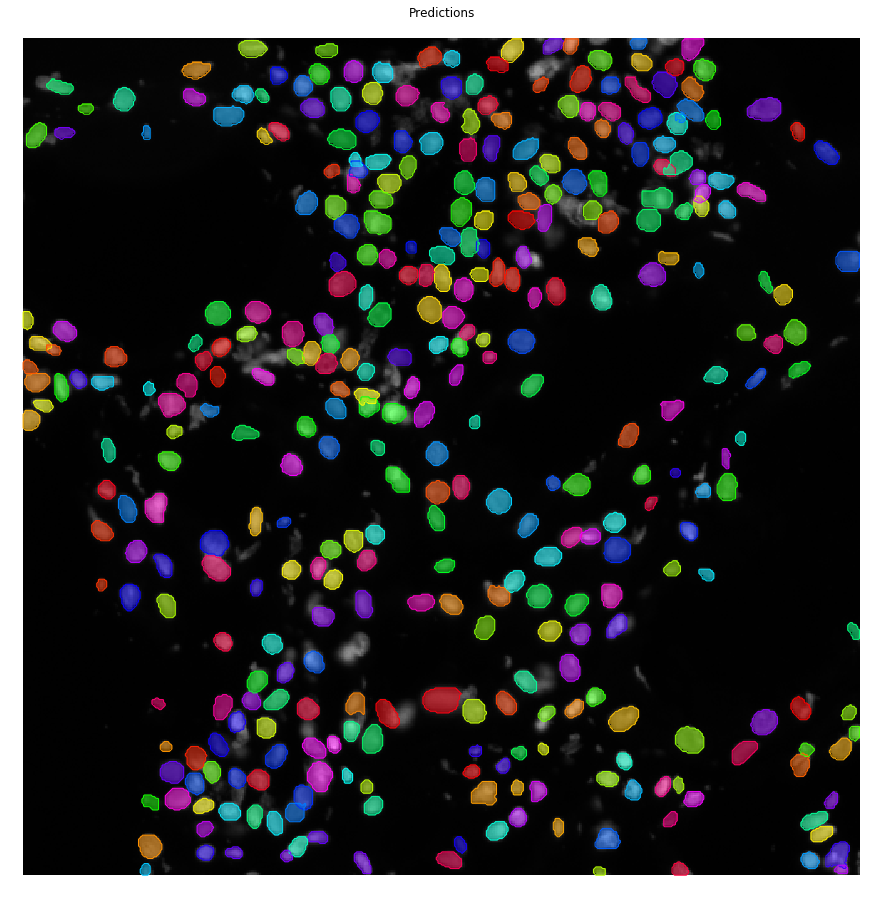

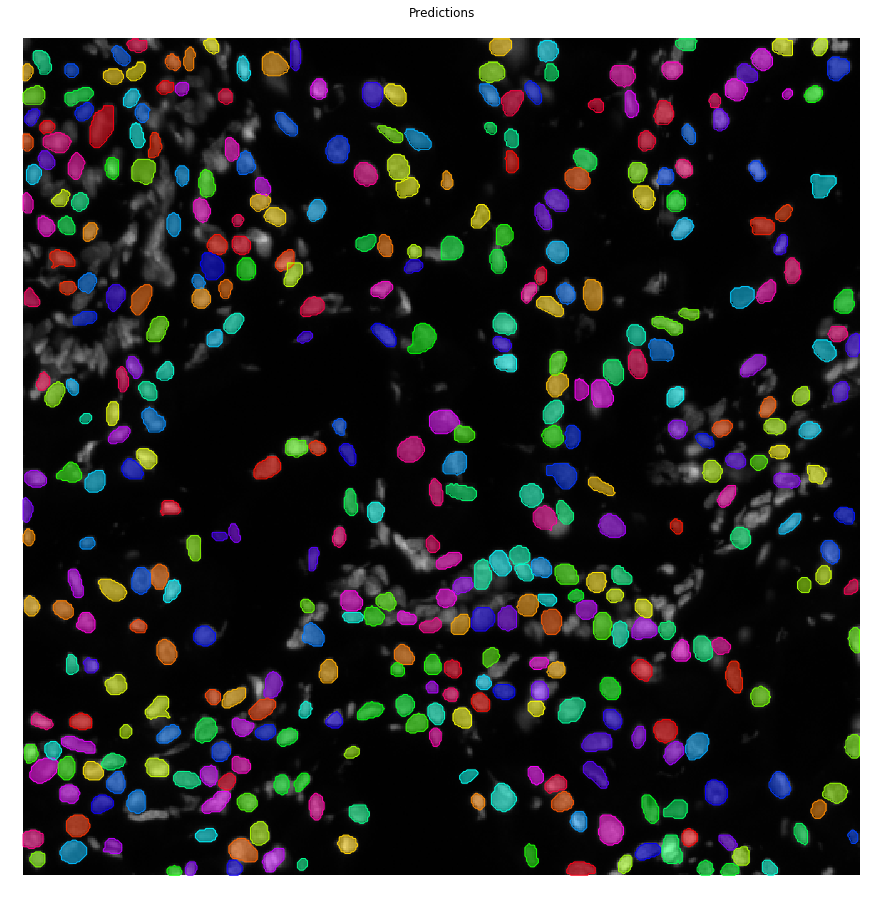

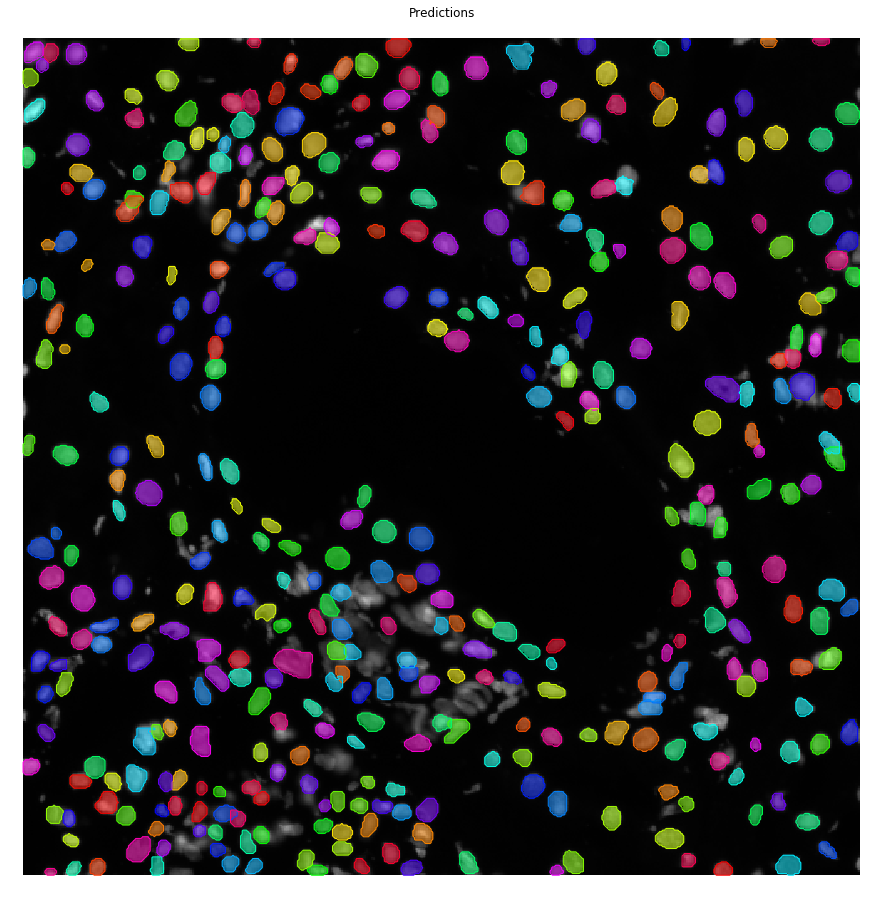

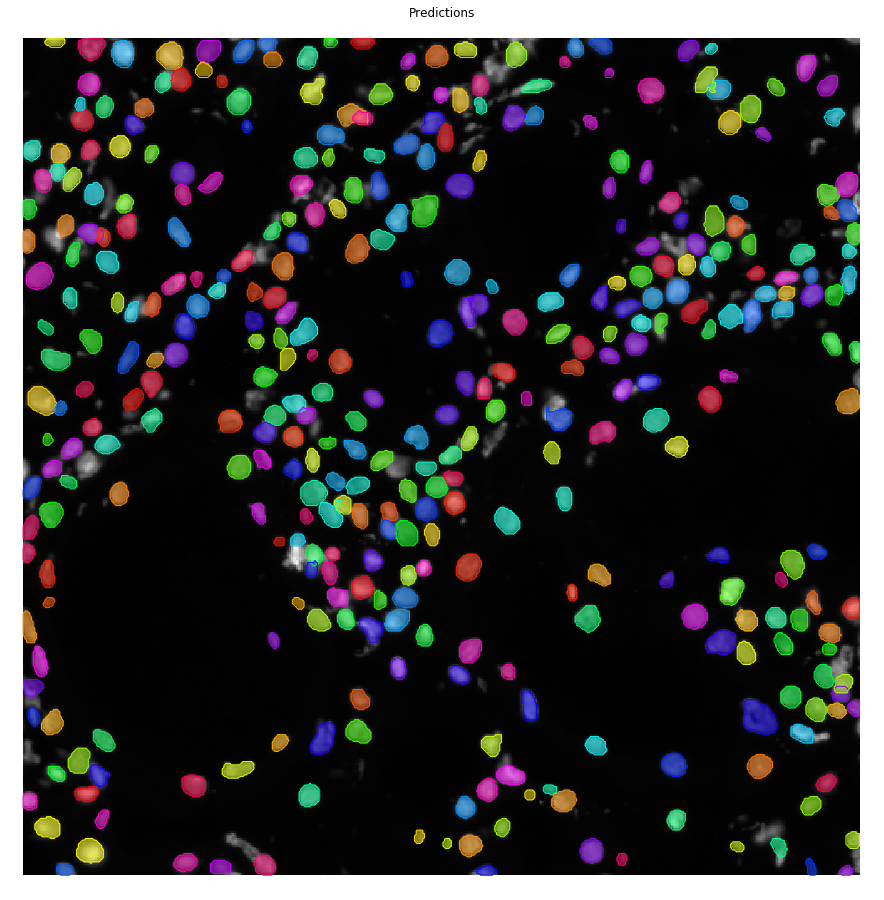

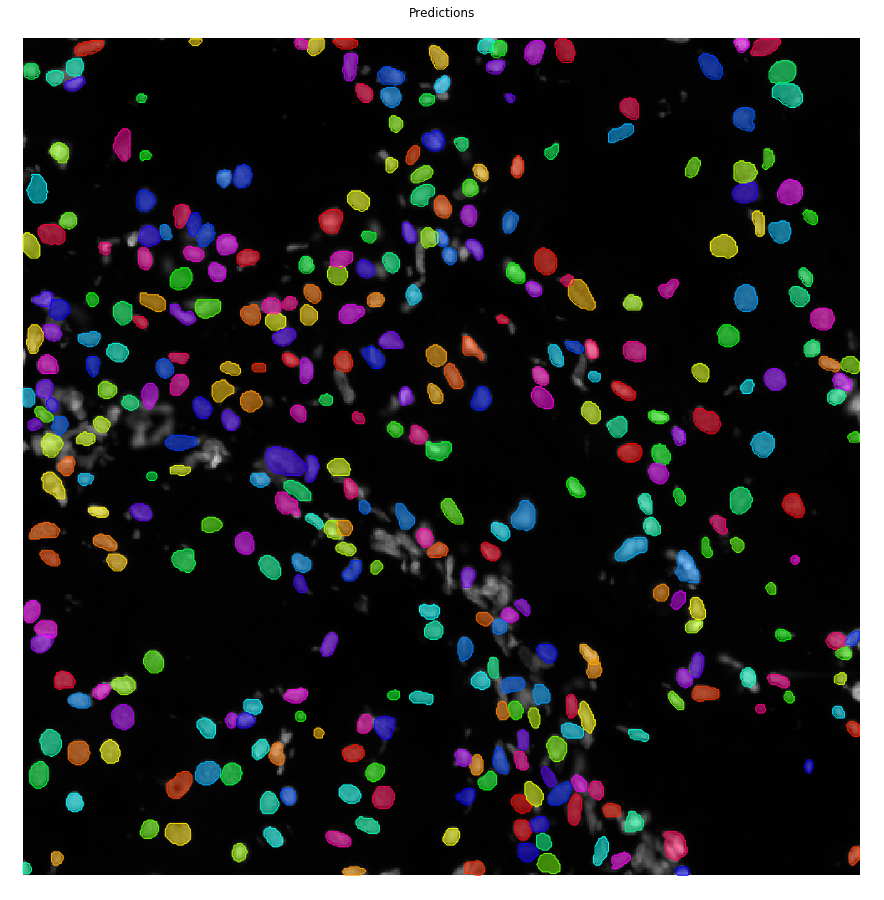

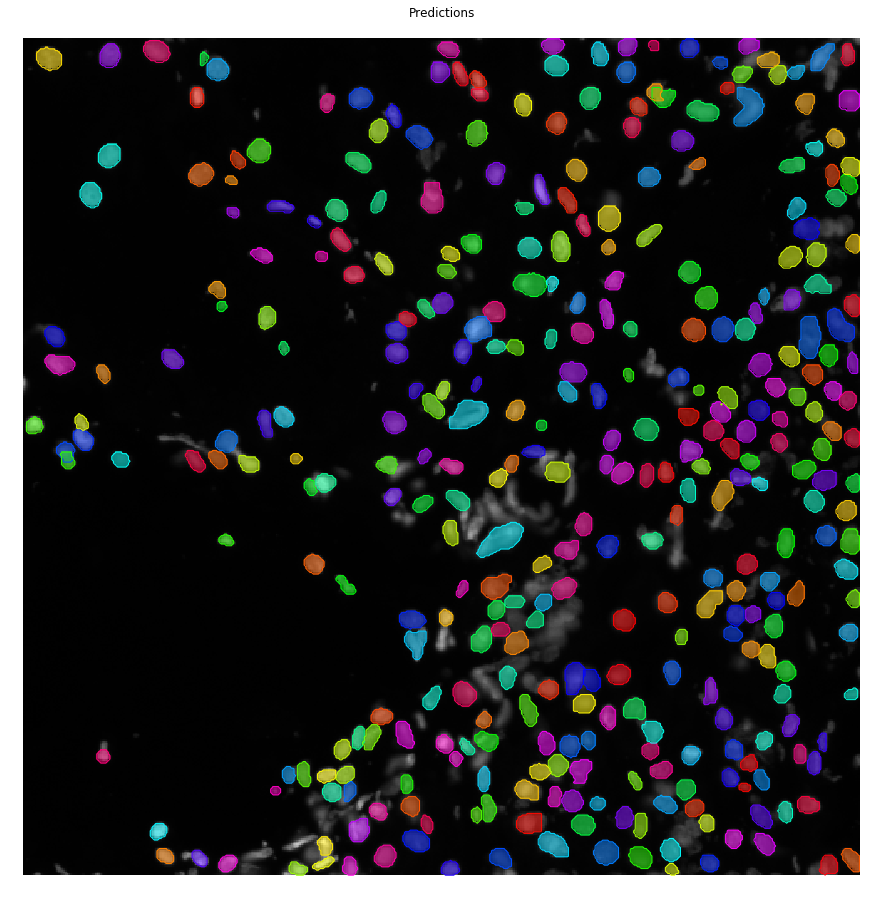

Saved to  C:\Users\sumee\Desktop\RA\nuclei segmentation\Mask RCNN\results\submit_20200517T202142


In [14]:
submission = []
for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    
    r = model.detect([image], verbose=0)[0]
    
    source_id = dataset.image_info[image_id]["id"]
    rle = nucleus.mask_to_rle(source_id, r["masks"], r["scores"])
    submission.append(rle)
    
    saveto="{}/{}_result.png".format(submit_dir, dataset.image_info[image_id]["id"][:-4])
    
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], 
                                show_bbox=False, show_mask=True, title="Predictions",save_as=saveto)
    
#     plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))
    
submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
file_path = os.path.join(submit_dir, "submit.csv")
with open(file_path, "w") as f:
    f.write(submission)
print("Saved to ", submit_dir)

## Detection on Kaggle dataset
#### Loading Data

In [ ]:
DATASET_DIR = os.path.join(ROOT_DIR, "kaggle data")
dataset_test = nucleus.NucleusDataset()
dataset_test.load_nucleus(DATASET_DIR, "stage1_test")
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

#### Creating the results sub-directory

In [ ]:
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
submit_dir = os.path.join(RESULTS_DIR, submit_dir)
os.makedirs(submit_dir)

#### Detection

In [ ]:
submission = []
for image_id in dataset_test.image_ids:
    image = dataset_test.load_image(image_id)
    
    r = model.detect([image], verbose=0)[0]
    
    source_id = dataset_test.image_info[image_id]["id"]
    rle = nucleus.mask_to_rle(source_id, r["masks"], r["scores"])
    submission.append(rle)
    
    save_to="{}/{}.png".format(submit_dir, dataset_test.image_info[image_id]["id"])
    visualize.display_instances(
        image, r['rois'], r['masks'], r['class_ids'],
         r['scores'],
        show_bbox=False, show_mask=True,
        title="Predictions",save_as=save_to)
#     plt.savefig("{}/{}.png".format(submit_dir, dataset_test.image_info[image_id]["id"]))
    
submission1 = "ImageId,EncodedPixels\n" + "\n".join(submission)
file_path = os.path.join(submit_dir, "submit.csv")
with open(file_path, "w") as f:
    f.write(submission1)
print("Saved to ", submit_dir)